<a href="https://colab.research.google.com/github/GoldenWanGila/Collage-Project/blob/master/%E9%80%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from numpy.core import numeric
import seaborn as sns; sns.set()
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sklearn.linear_model
import os
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sympy import *
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from math import sqrt


上面import基本函式與模組
下方將資料集做初步整理

In [ ]:
rail = pd.read_csv("/content/drive/MyDrive/railway.csv")
rail = rail.dropna()
rail = rail.drop([22157])
rail = rail.drop([291763])

rail = rail[rail["date"]>='2021/01/22']
rail = rail[rail["date"]!="2021/04/02"]
rail = rail[rail["date"]!="2021/04/03"]
rail = rail[rail["date"]!="2020/12/23"]

rail.sort_values(by=["time","date"],inplace=True)

railk = rail.drop([17843,31329,67649,86012,97407,213698,228742,268295,294956,308274,19061,32757,69430,87149,98951,215076,230141,269998,284593,296192,309812,283598,125238,127616])
#早6-9、晚5-8
#rail=rail.drop([28684,42104,83423,94652,109189,241119,281214,320035,225222])
#rail=rail.drop([9554,25464,38332,78755,91610,105023,136664,160110,178243,194730,220481,237466 ,257552 ,276670,288466,302440,315877]) 


In [ ]:
#縱北(豐原以北)
listn = [103,105,109,113,115,117,119,159,121,123,125,129,275,135,175,139,141,177,145,147,185,149,181,473,155]
railn = rail[rail["num"].isin(listn)]
#竹南、新竹
listn2 = [103,105,109,115,117,119,159,121,123,125,275,135,175,139,141,177,145,147,185,149,473,155]
railn2 = railk[railk["num"].isin(listn2)]
#苗栗、竹南
listn22 = [105,115,117,121,123,125,275,135,175,139,141,147,177,149,473,155]
railn22 = railk[railk["num"].isin(listn22)]
#山線(苗中彰)
list = [105,113,115,117,121,123,125,129,275,135,175,139,141,147,177,149,181,473,155]
rail = railk[railk["num"].isin(list)]
#301(中豐),101(豐),371(豐),167(中豐),105,...,373(中豐),135,175,139,141,177,143(豐員),147(員),149,181,473(員),155(員)  
#丟:22157
list27 = [105,113,115,117,121,123,125,129,135,175,139,141,149,181]
rail27 = rail[rail["num"].isin(list27)]
#縱南(員雲嘉南高)
lists = [101,371,167,103,105,113,115,117,121,123,125,129,373,135,175,139,141,145,185,149]
rails = railk[railk["num"].isin(lists)]

**事故調整**

1.[情報] 富岡號誌故障 2/10 115車次
https://www.ptt.cc/bbs/Railway/M.1612924168.A.105.html

In [ ]:
#print(rail[rail["num"]==177][rail["date"]=="2021/02/10"])
#177有停潭子=.=
print(rail[rail["num"]==115][rail["date"]=="2021/02/10"])
#railn外刪除之
print(rail[rail["num"]==121][rail["date"]=="2021/02/26"])
#待研究 視為事故>>豐原大delay>>railn外刪除之
#print(rail[rail["num"]==139][rail["date"]=="2021/02/27"])
#待研究 視為事故>>此處不做調整、推測421次delay影響
#print(rail[rail["num"]==129][rail["date"]=="2021/03/21"])
#非待避 視為事故>>中壢以北561車次卡死>>此處不做調整

        Station  direction  id        date   time  num      dest  delay type
44344   Keelung          0  14  2021/02/10  08:14  115  Pingtung    1.0    B
185830    Xizhi          0  25  2021/02/10  08:38  115  Pingtung    4.0    B
245245   Taipei          0  35  2021/02/10  08:59  115  Pingtung    3.0    B
147674  Banqiao          0  36  2021/02/10  09:09  115  Pingtung    3.0    B
170453  Taoyuan          0  25  2021/02/10  09:33  115  Pingtung    1.0    B
2002    Zhongli          0  23  2021/02/10  09:44  115  Pingtung    3.0    B
        Station  direction  id        date   time  num      dest  delay type
187655    Xizhi          0  40  2021/02/26  10:40  121  Pingtung    3.0    B
247783   Taipei          0  49  2021/02/26  11:00  121  Pingtung    2.0    B
150210  Banqiao          0  50  2021/02/26  11:10  121  Pingtung    1.0    B
172032  Taoyuan          0  34  2021/02/26  11:30  121  Pingtung    0.0    B
3533    Zhongli          0  32  2021/02/26  11:41  121  Pingtung    0.0    B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


針對不同區域取合適的資料來做分析(基隆、汐止、台北不參與實驗，因為會受東部發車影響)

In [ ]:
label_map = {'Keelung':1,'Xizhi':2,'Taipei':3,'Banqiao':4,'Taoyuan':5,'Zhongli':6,'Hsinchu':7,'Zhunan':8,'Miaoli':9,'Fengyuan':10,'Taichung':11,'Changhua':12,
'Yuanlin':13,'Douliu':14,'Chiayi':15,'Tainan':16,'Xinzuoying':17,'Kaohsiung':18,'Tanzi':0,'Taiyuan':0,'Xinwuri':0}

railkl = railn[railn["Station"]=='Keelung']
railxz = railn[railn["Station"]=='Xizhi']

railtp = railn[railn["Station"]=='Taipei']
railbq = railn[railn["Station"]=='Banqiao']
railc = railn[railn["Station"]=='Taoyuan']
raild = railn[railn["Station"]=='Zhongli']
raildd = raild.drop([268,361,455,553,647,742,836])
raile = railn[railn["Station"]=='Hsinchu']
raile1 = rail[rail["Station"]=='Hsinchu']
raile2 = railn2[railn2["Station"]=='Hsinchu']
railzn2 = railn2[railn2["Station"]=='Zhunan']
railzn = railn22[railn22["Station"]=='Zhunan']
rail00 = railn22[railn22["Station"]=='Miaoli']
rail0 = rail[rail["Station"]=='Miaoli']
rail1 = rail[rail["Station"]=='Fengyuan']
rail1e = rail1.drop([293549,293625,293703,293780,293856,293932,294008])
rail2 = rail[rail["Station"]=='Taichung']
rail3 = rail[rail["Station"]=='Changhua']
rail33 = rails[rails["Station"]=='Changhua']
rail4 = rails[rails["Station"]=='Yuanlin']
rail5 = rails[rails["Station"]=='Douliu']
rail6 = rails[rails["Station"]=='Chiayi']
rail7 = rails[rails["Station"]=='Tainan']
rail78 = rail7.drop([266464])
rail8 = rails[rails["Station"]=='Xinzuoying']
rail9 = rails[rails["Station"]=='Kaohsiung']

In [ ]:
new_ticks = np.linspace(0,49,50)

以一線大站(台北、台中、台南、高雄)以及準一線大站作分析(板橋、新竹、...)

https://www.ptt.cc/bbs/Railway/M.1584344432.A.3E2.html

https://www.ptt.cc/bbs/Railway/M.1584293270.A.298.html

自強號逆行即為西部南下，因此多數以一線大站南下以及北部車站為中心、中短途路線來做分析

重點路段: 台北板橋>桃竹    
桃竹>台中

中彰>嘉南 

嘉南>新左營、高雄

1.台北到板橋



Modela slope:     0.9864595488928558
Modela intercept: -0.008802746614221979
LinearRegression Score:  0.9259218261320482


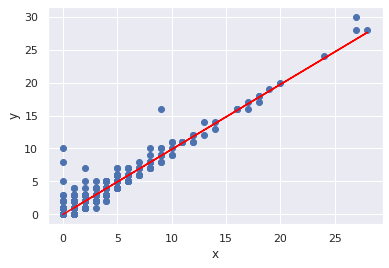

0.9864595488928558
-0.008802746614221979
{xtp: -0.650107337234696, ybq: -0.650107337234696}
算出允許誤差
xgboost、lasso比較
[04:00:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9358226856475054


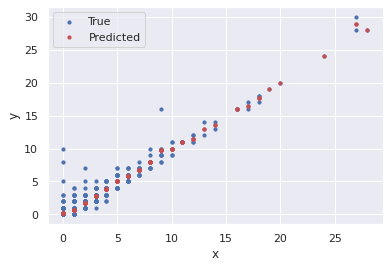

ls Score:  0.9215068874279236
0.7781542042942593


In [ ]:
xtp= railtp["delay"].to_numpy()
ybq= railbq["delay"].to_numpy()
xtp= xtp.reshape(-1,1)
modela = LinearRegression(fit_intercept=True)
modela.fit(xtp, ybq)
print("Modela slope:    ", modela.coef_[0])
print("Modela intercept:", modela.intercept_)
print("LinearRegression Score: ",modela.score(xtp,ybq))
predict = modela.predict(xtp)
plt.plot(xtp,predict,c="red")
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xtp,ybq)
plt.show()

k=modela.coef_[0]
l= modela.intercept_
print(k)
print(l)
x,y = symbols('xtp,ybq')
print(solve([k*x+l-y,x-y],[x,y]))
print("算出允許誤差")
print("xgboost、lasso比較")
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xtp,ybq)
predicted1=xgbrModel.predict(xtp)
print("xg Score: ",xgbrModel.score(xtp,ybq))
plt.scatter(xtp, ybq, s=10, label='True')
plt.scatter(xtp, predicted1, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

reg = Lasso(alpha=0.5) # 其中可以調整 alpha 值決定正則化的強度
reg.fit(xtp,ybq)
predicted1=reg.predict(xtp)
print("ls Score: ",reg.score(xtp,ybq))

v = mean_squared_error(ybq,predicted1)
print(sqrt(v))

**台北板橋safe**

2.台北到桃園

Modela slope:     0.9599474606905007
Modela intercept: 0.5756379708681838
LinearRegression Score:  0.7286885292496468


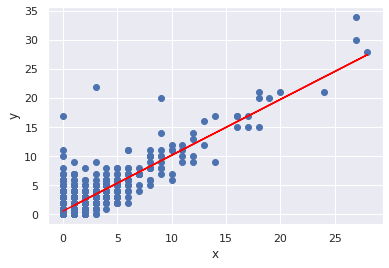

{xtp: 14.3720718034890, yc: 14.3720718034890}
算出允許誤差
xgboost、lasso比較
[04:00:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.7442833298790184


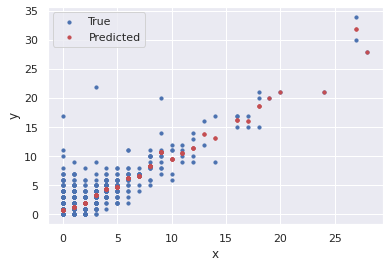

1.540684772737739


In [ ]:
xtp= railtp["delay"].to_numpy()
yc= railc["delay"].to_numpy()
xtp= xtp.reshape(-1,1)
modelaa = LinearRegression(fit_intercept=True)
modelaa.fit(xtp, yc)
print("Modela slope:    ", modelaa.coef_[0])
print("Modela intercept:", modelaa.intercept_)
print("LinearRegression Score: ",modelaa.score(xtp,yc))
predict = modelaa.predict(xtp)
plt.plot(xtp,predict,c="red")
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(xtp,yc)
plt.show()
k= modelaa.coef_[0]
l= modelaa.intercept_
x,y = symbols('xtp,yc')
print(solve([k*x+l-y,x-y],[x,y]))
print("算出允許誤差")
print("xgboost、lasso比較")
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xtp,yc)
predicted1=xgbrModel.predict(xtp)
print("xg Score: ",xgbrModel.score(xtp,yc))
plt.scatter(xtp, yc, s=10, label='True')
plt.scatter(xtp, predicted1, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

v = mean_squared_error(yc,predicted1)
print(sqrt(v))

**台北桃園safe**

3.台北到中壢

Modela slope:     0.9893644082362241
Modela intercept: 1.3965579274231439
LinearRegression Score:  0.6435359064186186


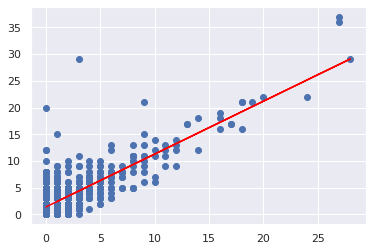

{xtp: 131.309847015726, yd: 131.309847015726}
算出允許誤差
xgboost、lasso比較
[04:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.6609889043073864


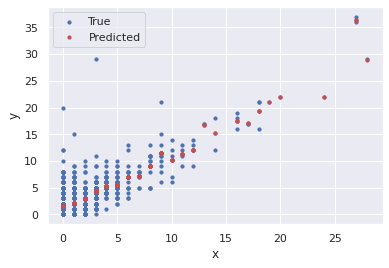

1.9455151622880997


In [ ]:
xtp= railtp["delay"].to_numpy()
yd= raild["delay"].to_numpy()
xtp= xtp.reshape(-1,1)
modelad = LinearRegression(fit_intercept=True)
modelad.fit(xtp, yd)
print("Modela slope:    ", modelad.coef_[0])
print("Modela intercept:", modelad.intercept_)
print("LinearRegression Score: ",modelad.score(xtp,yd))
predict = modelad.predict(xtp)
plt.plot(xtp,predict,c="red")
plt.scatter(xtp,yd)
plt.show()
k= modelad.coef_[0]
l= modelad.intercept_
x,y = symbols('xtp,yd')
print(solve([k*x+l-y,x-y],[x,y]))
print("算出允許誤差")
print("xgboost、lasso比較")
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xtp,yd)
predicted1=xgbrModel.predict(xtp)
print("xg Score: ",xgbrModel.score(xtp,yd))
plt.scatter(xtp, yd, s=10, label='True')
plt.scatter(xtp, predicted1, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(yd,predicted1)
print(sqrt(v))

**台北中壢注意!**

4.台北到新竹

Modela slope:     0.814047866805411
Modela intercept: 1.7252696055245484
LinearRegression Score:  0.36764434714852057


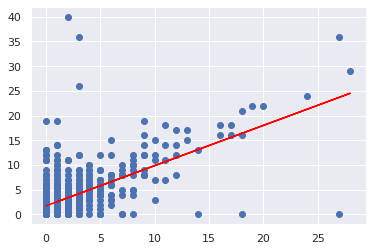

{xtp: 9.27803072696750, ye: 9.27803072696750}
算出允許誤差
xgboost、lasso比較
[04:00:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.3965942110537354


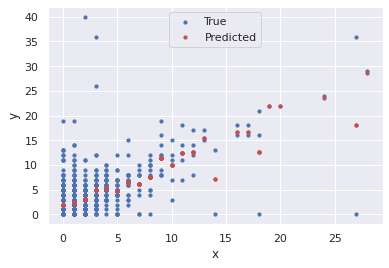

2.7944025521644806


In [ ]:
railtp1 = railtp.drop([242398,242553,242709,242871,243024,243176,243328])
xtp= railtp1["delay"].to_numpy()
ye= raile["delay"].to_numpy()
xtp= xtp.reshape(-1,1)
modelae = LinearRegression(fit_intercept=True)
modelae.fit(xtp,ye)
print("Modela slope:    ", modelae.coef_[0])
print("Modela intercept:", modelae.intercept_)
print("LinearRegression Score: ",modelae.score(xtp,ye))
predict = modelae.predict(xtp)
plt.plot(xtp,predict,c="red")
plt.scatter(xtp,ye)
plt.show()
k= modelae.coef_[0]
l= modelae.intercept_
x,y = symbols('xtp,ye')
print(solve([k*x+l-y,x-y],[x,y]))
print("算出允許誤差")
print("xgboost、lasso比較")
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xtp,ye)
predicted1=xgbrModel.predict(xtp)
print("xg Score: ",xgbrModel.score(xtp,ye))
plt.scatter(xtp, ye, s=10, label='True')
plt.scatter(xtp, predicted1, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(ye,predicted1)
print(sqrt(v))


**3/15 109 楊梅 https://www.ptt.cc/bbs/Railway/M.1615771361.A.8AC.html**

**台北新竹注意**

5.板橋到桃園

Modelb slope:     0.9864151223597857
Modelb intercept: 0.5670751217492316
LR Score:  0.8086315626751321


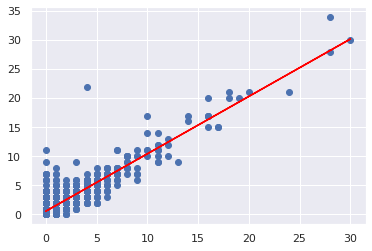

{xbp: 41.7431158945867, yc: 41.7431158945867}
[04:00:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8195197300870835


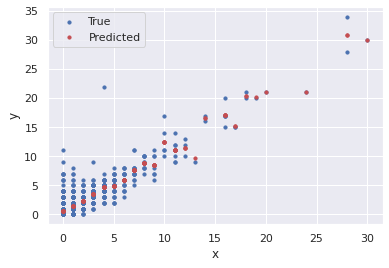

1.294342274538293


In [ ]:

xbq= railbq["delay"].to_numpy()
yc= railc["delay"].to_numpy()
xbq= xbq.reshape(-1,1)
modelb = LinearRegression(fit_intercept=True)
modelb.fit(xbq, yc)
print("Modelb slope:    ", modelb.coef_[0])
print("Modelb intercept:", modelb.intercept_)
print("LR Score: ",modelb.score(xbq,yc))
predict = modelb.predict(xbq)
plt.plot(xbq,predict,c="red")
plt.scatter(xbq,yc)
plt.show()
k= modelb.coef_[0]
l= modelb.intercept_
x,y = symbols('xbp,yc')
print(solve([k*x+l-y,x-y],[x,y]))

xgbrModel1=xgb.XGBRegressor()
xgbrModel1.fit(xbq,yc)
predicted3=xgbrModel1.predict(xbq)
print("xg Score: ",xgbrModel1.score(xbq,yc))
plt.scatter(xbq, yc, s=10, label='True')
plt.scatter(xbq, predicted3, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(yc,predicted3)
print(sqrt(v))

6.板橋到中壢

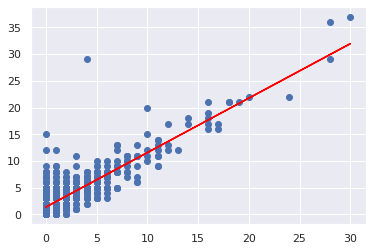

{xc: -72.5047883480995, yd: -72.5047883480995}
LR Score:  0.7175875330252095
[04:00:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.7357346345665055


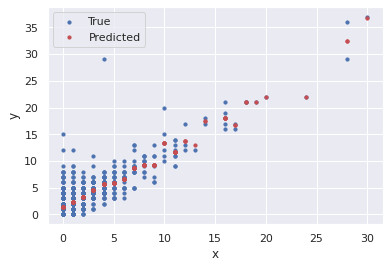

1.7448149980468883


In [ ]:

xc= railbq["delay"].to_numpy()
yd= raild["delay"].to_numpy()
xc= xc.reshape(-1,1)
modelc = LinearRegression(fit_intercept=True)
modelc.fit(xc, yd)
predict = modelc.predict(xc)
plt.plot(xc,predict,c="red")
plt.scatter(xc,yd)
plt.show()
k= modelc.coef_[0]
l= modelc.intercept_
x,y = symbols('xc,yd')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modelc.score(xc,yd))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xc,yd)
predicted2=xgbrModel.predict(xc)
print("xg Score: ",xgbrModel.score(xbq,yc))
plt.scatter(xc, yd, s=10, label='True')
plt.scatter(xc, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(yd,predicted2)
print(sqrt(v))

**板橋中壢注意**

61.板橋到新竹

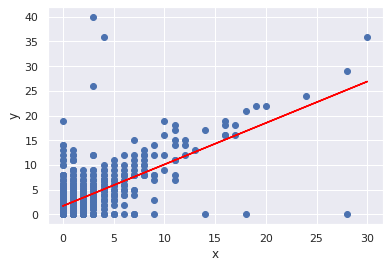

{xc1: 10.6736879737196, yd: 10.6736879737196}
LR Score:  0.40968829336199186
[04:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.4490909361138375


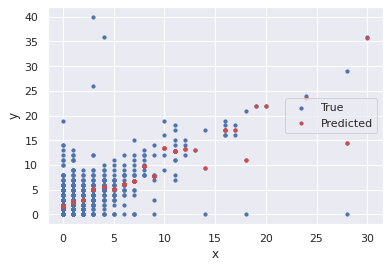

2.67007949706895


In [ ]:

xc1= railbq.drop([144829,144984,145140,145301,145453,145605,145758])
xc1= xc1["delay"].to_numpy()
yd= raile["delay"].to_numpy()
xc1= xc1.reshape(-1,1)
modelc1 = LinearRegression(fit_intercept=True)
modelc1.fit(xc1, yd)
predict = modelc1.predict(xc1)
plt.plot(xc1,predict,c="red")
plt.scatter(xc1,yd)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= modelc1.coef_[0]
l= modelc1.intercept_
x,y = symbols('xc1,yd')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modelc1.score(xc1,yd))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xc1,yd)
predicted2=xgbrModel.predict(xc1)
print("xg Score: ",xgbrModel.score(xc1,yd))
plt.scatter(xc1, yd, s=10, label='True')
plt.scatter(xc1, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(yd,predicted2)
print(sqrt(v))

**板橋新竹注意**

7.桃園到新竹

Modeld slope:     0.8717546676741917
Modeld intercept: 1.1983966184943797


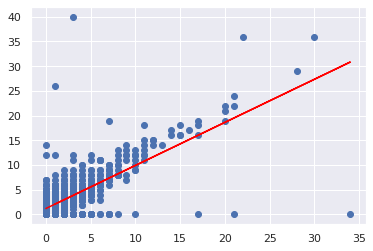

{xd1: 9.34456324265936, ye: 9.34456324265936}
LR Score:  0.5333730294822789
[04:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.614984091719942


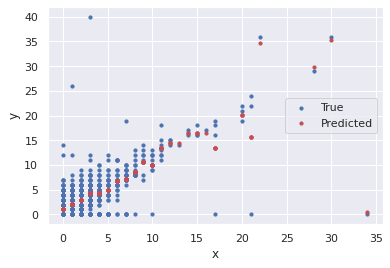

2.2321509995666204


In [ ]:

xd = railc.drop([168663,168758,168856,168956,169054,169152,169249])
xd1= xd["delay"].to_numpy()
ye= raile["delay"].to_numpy()
xd1= xd1.reshape(-1,1)
modeld = LinearRegression(fit_intercept=True)
modeld.fit(xd1, ye)
print("Modeld slope:    ", modeld.coef_[0])
print("Modeld intercept:", modeld.intercept_)
predict = modeld.predict(xd1)
plt.plot(xd1,predict,c="red")
plt.scatter(xd1,ye)
plt.show()
k= modeld.coef_[0]
l= modeld.intercept_
x,y = symbols('xd1,ye')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modeld.score(xd1,ye))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xd1,ye)
predicted2=xgbrModel.predict(xd1)
print("xg Score: ",xgbrModel.score(xd1,ye))
plt.scatter(xd1, ye, s=10, label='True')
plt.scatter(xd1, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(ye,predicted2)
print(sqrt(v))


**桃園新竹注意**

71桃園到中壢

modelcc slope:     1.0577625308162966
modelcc intercept: 0.7534278957781588


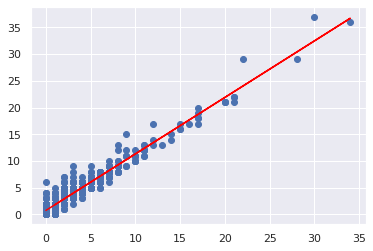

{xc1: -13.0435402523178, ydd: -13.0435402523178}
LR Score:  0.930228349648173
[04:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9357438957881336


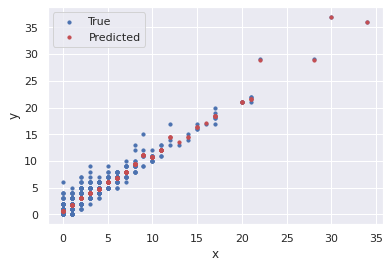

0.8470028253717029


In [ ]:

xc1= railc["delay"].to_numpy()
ydd= raild["delay"].to_numpy()
xc1= xc1.reshape(-1,1)
modelcc = LinearRegression(fit_intercept=True)
modelcc.fit(xc1, ydd)
print("modelcc slope:    ", modelcc.coef_[0])
print("modelcc intercept:", modelcc.intercept_)
predict = modelcc.predict(xc1)
plt.plot(xc1,predict,c="red")
plt.scatter(xc1,ydd)
plt.show()
k= modelcc.coef_[0]
l= modelcc.intercept_
x,y = symbols('xc1,ydd')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modelcc.score(xc1,ydd))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xc1,ydd)
predicted2=xgbrModel.predict(xc1)
print("xg Score: ",xgbrModel.score(xc1,ydd))
plt.scatter(xc1, ydd, s=10, label='True')
plt.scatter(xc1, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(ydd,predicted2)
print(sqrt(v))

**pass**

7.中壢到新竹

Modeld slope:     0.841893906368407
Modeld intercept: 0.5288156165368374


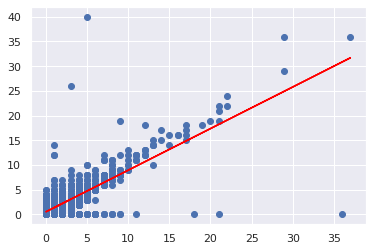

{xd: 3.34468839492704, ye: 3.34468839492704}
LR Score:  0.60157811011565
[04:00:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.6853910269801446


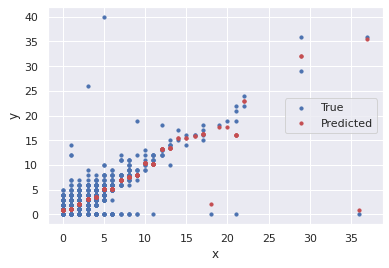

2.0177612881917875


In [ ]:

xd= raildd["delay"].to_numpy()
ye= raile["delay"].to_numpy()
xd= xd.reshape(-1,1)
modeld = LinearRegression(fit_intercept=True)
modeld.fit(xd, ye)
print("Modeld slope:    ", modeld.coef_[0])
print("Modeld intercept:", modeld.intercept_)
predict = modeld.predict(xd)
plt.plot(xd,predict,c="red")
plt.scatter(xd,ye)
plt.show()
k= modeld.coef_[0]
l= modeld.intercept_
x,y = symbols('xd,ye')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modeld.score(xd,ye))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xd,ye)
predicted2=xgbrModel.predict(xd)
print("xg Score: ",xgbrModel.score(xd,ye))
plt.scatter(xd, ye, s=10, label='True')
plt.scatter(xd, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(ye,predicted2)
print(sqrt(v))

**中壢新竹調整減減一分鐘**

8.新竹到竹南

Modele2 slope:     1.0304939700935944
Modele2 intercept: -0.200314739773241


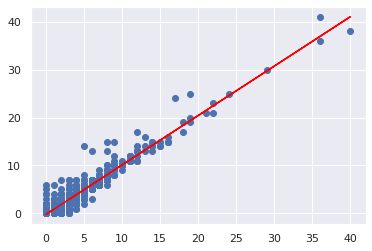

{xe2: 6.56899508848631, ye2: 6.56899508848631}
LR Score:  0.9248048825081961
[04:00:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9347882517574978


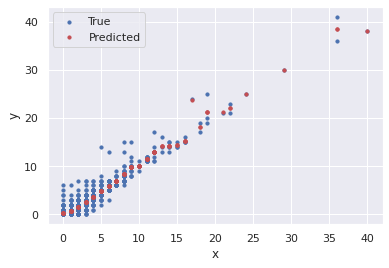

0.9982803635257534


In [ ]:

xe2= raile2["delay"].to_numpy()
ye2= railzn2["delay"].to_numpy()
xe2= xe2.reshape(-1,1)
modele2 = LinearRegression(fit_intercept=True)
modele2.fit(xe2, ye2)
print("Modele2 slope:    ", modele2.coef_[0])
print("Modele2 intercept:", modele2.intercept_)
predict = modele2.predict(xe2)
plt.plot(xe2,predict,c="red")
plt.scatter(xe2,ye2)
plt.show()
k= modele2.coef_[0]
l= modele2.intercept_
x,y = symbols('xe2,ye2')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modele2.score(xe2,ye2))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xe2,ye2)
predicted2=xgbrModel.predict(xe2)
print("xg Score: ",xgbrModel.score(xe2,ye2))
plt.scatter(xe2, ye2, s=10, label='True')
plt.scatter(xe2, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(ye2,predicted2)
print(sqrt(v))

9.新竹到台中

Modele1 slope:     0.8951256754201825
Modele1 intercept: 0.03981905758040716


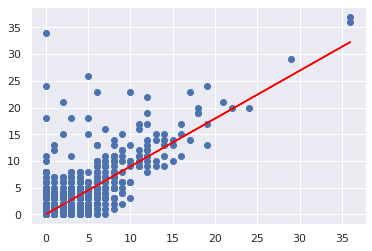

{xe1: 0.379683566401441, ye1: 0.379683566401441}
LR Score:  0.5503219064623721
[04:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.593363731283636


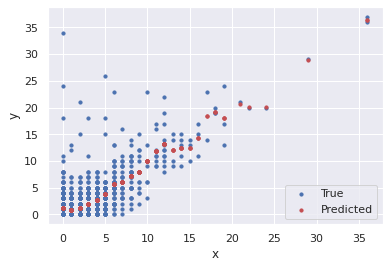

2.724668191026524


In [ ]:
ye1 = rail2.drop([227151,227238,227326,227413,227500,227586,227672])
xe1= raile1["delay"].to_numpy()
ye1= ye1["delay"].to_numpy()
xe1= xe1.reshape(-1,1)
modele1 = LinearRegression(fit_intercept=True)
modele1.fit(xe1, ye1)
print("Modele1 slope:    ", modele1.coef_[0])
print("Modele1 intercept:", modele1.intercept_)
predict = modele1.predict(xe1)
plt.plot(xe1,predict,c="red")
plt.scatter(xe1,ye1)
plt.show()
k= modele1.coef_[0]
l= modele1.intercept_
x,y = symbols('xe1,ye1')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",modele1.score(xe1,ye1))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(xe1,ye1)
predicted2=xgbrModel.predict(xe1)
print("xg Score: ",xgbrModel.score(xe1,ye1))
plt.scatter(xe1, ye1, s=10, label='True')
plt.scatter(xe1, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(ye1,predicted2)
print(sqrt(v))

**台中新竹注意**

10.竹南到苗栗

Model0z slope:     0.9682831796015994
Model0z intercept: -0.30770748722822505


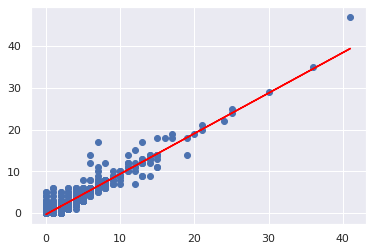

{x0z: -9.70171295114242, y0z: -9.70171295114242}
LR Score:  0.907484902215055
[04:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9233079731070807


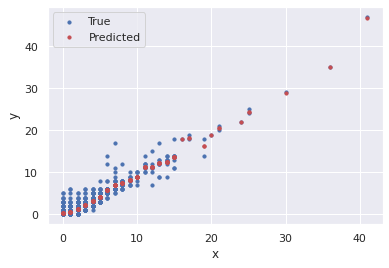

1.107045322431998


In [ ]:


y0z= rail00["delay"].to_numpy()
x0z= railzn["delay"].to_numpy()
x0z= x0z.reshape(-1,1)
model0z = LinearRegression(fit_intercept=True)
model0z.fit(x0z, y0z)
print("Model0z slope:    ", model0z.coef_[0])
print("Model0z intercept:", model0z.intercept_)
predict = model0z.predict(x0z)
plt.plot(x0z,predict,c="red")
plt.scatter(x0z,y0z)
plt.show()
k= model0z.coef_[0]
l= model0z.intercept_
x,y = symbols('x0z,y0z')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model0z.score(x0z,y0z))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x0z,y0z)
predicted1=xgbrModel.predict(x0z)
print("xg Score: ",xgbrModel.score(x0z,y0z))
plt.scatter(x0z, y0z, s=10, label='True')
plt.scatter(x0z, predicted1, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y0z,predicted1)
print(sqrt(v))

11.苗栗到豐原

Model0 slope:     0.9555873910413587
Model0 intercept: -0.01180556250329401


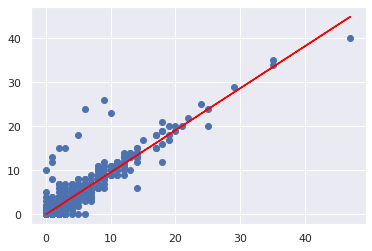

{x0: -0.265815559592274, y0: -0.265815559592274}
LR Score:  0.8506878881717596
[04:00:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8597215368149697


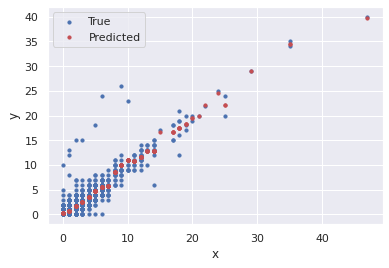

1.5867316577456902


In [ ]:
x0= rail0["delay"].to_numpy()
y0= rail1["delay"].to_numpy()
x0= x0.reshape(-1,1)
model0 = LinearRegression(fit_intercept=True)
model0.fit(x0, y0)
print("Model0 slope:    ", model0.coef_[0])
print("Model0 intercept:", model0.intercept_)
predict = model0.predict(x0)
plt.plot(x0,predict,c="red")
plt.scatter(x0,y0)
plt.show()
k= model0.coef_[0]
l= model0.intercept_
x,y = symbols('x0,y0')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model0.score(x0,y0))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x0,y0)
predicted2=xgbrModel.predict(x0)
print("xg Score: ",xgbrModel.score(x0,y0))
plt.scatter(x0, y0, s=10, label='True')
plt.scatter(x0, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y0,predicted2)
print(sqrt(v))

**苗栗豐原減一分**

12.豐原到台中

Model1 slope:     0.9912511388607351
Model1 intercept: 0.04163662933522971


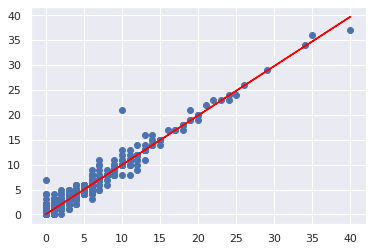

{x1: 4.75909134599976, y1: 4.75909134599976}
LR Score:  0.9593695913084717
[04:00:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9631531631784012


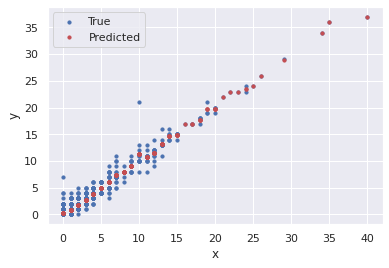

0.8229980713389137


In [ ]:

x1= rail1["delay"].to_numpy()
y1= rail2["delay"].to_numpy()
x1= x1.reshape(-1,1)
model1 = LinearRegression(fit_intercept=True)
model1.fit(x1, y1)
print("Model1 slope:    ", model1.coef_[0])
print("Model1 intercept:", model1.intercept_)
predict = model1.predict(x1)
plt.plot(x1,predict,c="red")
plt.scatter(x1,y1)
plt.show()
k= model1.coef_[0]
l= model1.intercept_
x,y = symbols('x1,y1')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model1.score(x1,y1))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x1,y1)
predicted2=xgbrModel.predict(x1)
print("xg Score: ",xgbrModel.score(x1,y1))
plt.scatter(x1, y1, s=10, label='True')
plt.scatter(x1, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y1,predicted2)
print(sqrt(v))

**pass**

In [ ]:
rail2 = rail[rail["Station"]=='Taichung']
rail3 = rail[rail["Station"]=='Changhua']
rail33 = rails[rails["Station"]=='Changhua']
rail4 = rails[rails["Station"]=='Yuanlin']
rail5 = rails[rails["Station"]=='Douliu']
rail6 = rails[rails["Station"]=='Chiayi']
rail7 = rails[rails["Station"]=='Tainan']
rail78 = rail7.drop([266464])
rail8 = rails[rails["Station"]=='Xinzuoying']
rail9 = rails[rails["Station"]=='Kaohsiung']

13.台中到彰化

Model2 slope:     0.9897168031740631
Model2 intercept: 0.1338219286143736


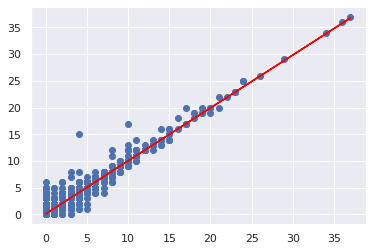

{x2: 13.0136504123736, y2: 13.0136504123736}
LR Score:  0.9406699111199216
[04:00:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9450927691670533


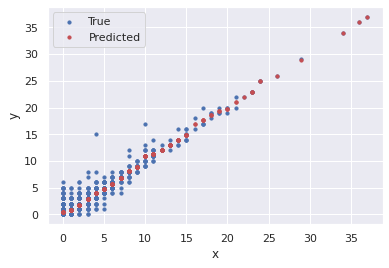

1.0251933959981103


In [ ]:

x2= rail2["delay"].to_numpy()
y2= rail3["delay"].to_numpy()
x2= x2.reshape(-1,1)
model2 = LinearRegression(fit_intercept=True)
model2.fit(x2, y2)
print("Model2 slope:    ", model2.coef_[0])
print("Model2 intercept:", model2.intercept_)
predict = model2.predict(x2)
plt.plot(x2,predict,c="red")
plt.scatter(x2,y2)
plt.show()
k= model2.coef_[0]
l= model2.intercept_
x,y = symbols('x2,y2')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model2.score(x2,y2))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x2,y2)
predicted2=xgbrModel.predict(x2)
print("xg Score: ",xgbrModel.score(x2,y2))
plt.scatter(x2, y2, s=10, label='True')
plt.scatter(x2, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y2,predicted2)
print(sqrt(v))

**台中彰化減一分**

14.台中到台南

Model27 slope:     0.8486951612867188
Model27 intercept: 1.8647173339748115


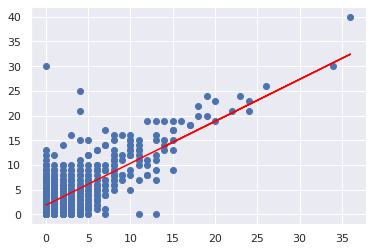

{x27: 12.3242412459023, y27: 12.3242412459023}
LR Score:  0.5360146545329062
[04:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.569619492516499


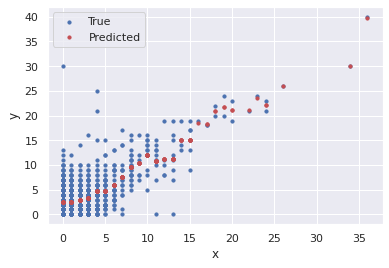

2.99278124539692


In [ ]:
x271 = rail27[rail27["Station"]=="Taichung"]
x27= x271["delay"].to_numpy()
y271 = rail27[rail27["Station"]=="Tainan"]
y27= y271["delay"].to_numpy()
x27= x27.reshape(-1,1)
model27 = LinearRegression(fit_intercept=True)
model27.fit(x27, y27)
print("Model27 slope:    ", model27.coef_[0])
print("Model27 intercept:", model27.intercept_)
predict = model27.predict(x27)
plt.plot(x27,predict,c="red")
plt.scatter(x27,y27)
plt.show()
k= model27.coef_[0]
l= model27.intercept_
x,y = symbols('x27,y27')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model27.score(x27,y27))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x27,y27)
predicted27=xgbrModel.predict(x27)
print("xg Score: ",xgbrModel.score(x27,y27))
plt.scatter(x27, y27, s=10, label='True')
plt.scatter(x27, predicted27, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y27,predicted27)
print(sqrt(v))


**台中台南調整**

15.彰化到台南

Model3 slope:     0.8745766713239109
Model3 intercept: 1.5381107685959194


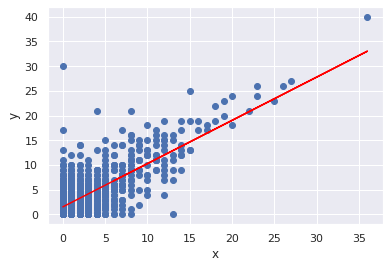

{x37: 12.2633547110534, y37: 12.2633547110534}
LR Score:  0.5414820501283318
[04:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.5671945296159738


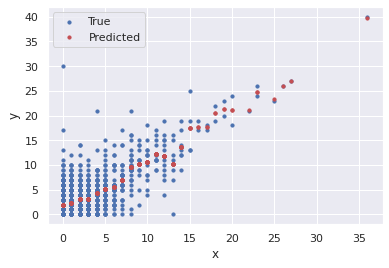

2.84940084715658


In [ ]:

x37= rail33["delay"].to_numpy()
y37= rail7["delay"].to_numpy()
x37= x37.reshape(-1,1)
model3 = LinearRegression(fit_intercept=True)
model3.fit(x37, y37)
print("Model3 slope:    ", model3.coef_[0])
print("Model3 intercept:", model3.intercept_)
predict = model3.predict(x37)
plt.plot(x37,predict,c="red")
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x37,y37)
plt.show()
k= model3.coef_[0]
l= model3.intercept_
x,y = symbols('x37,y37')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model3.score(x37,y37))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x37,y37)
predicted2=xgbrModel.predict(x37)
print("xg Score: ",xgbrModel.score(x37,y37))
plt.scatter(x37, y37, s=10, label='True')
plt.scatter(x37, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y37,predicted2)
print(sqrt(v))


**彰化台南調整**

15.彰化到員林

Model3 slope:     0.9953794601428829
Model3 intercept: 0.33961915964233125


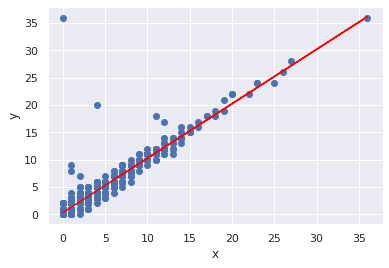

{x3: 73.5020517395206, y3: 73.5020517395206}
LR Score:  0.8794852797406157
[04:00:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8819808307944658


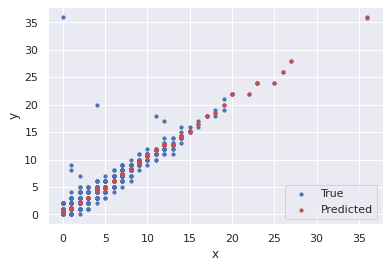

1.3287766438802364


In [ ]:

x3= rail33["delay"].to_numpy()
y3= rail4["delay"].to_numpy()
x3= x3.reshape(-1,1)
model3 = LinearRegression(fit_intercept=True)
model3.fit(x3, y3)
print("Model3 slope:    ", model3.coef_[0])
print("Model3 intercept:", model3.intercept_)
predict = model3.predict(x3)
plt.plot(x3,predict,c="red")
plt.scatter(x3,y3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model3.coef_[0]
l= model3.intercept_
x,y = symbols('x3,y3')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model3.score(x3,y3))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x3,y3)
predicted2=xgbrModel.predict(x3)
print("xg Score: ",xgbrModel.score(x3,y3))
plt.scatter(x3, y3, s=10, label='True')
plt.scatter(x3, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y3,predicted2)
print(sqrt(v))

**pass**

16.員林到斗六

Model4 slope:     0.9418512245262348
Model4 intercept: 0.2475947067449673


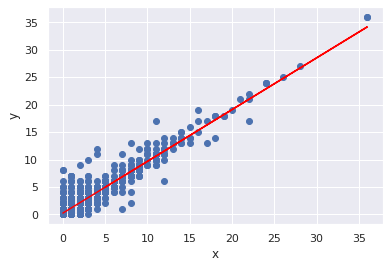

{x4: 4.25795220497247, y4: 4.25795220497247}
LR Score:  0.8893014392391293
[04:00:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8947733291028915


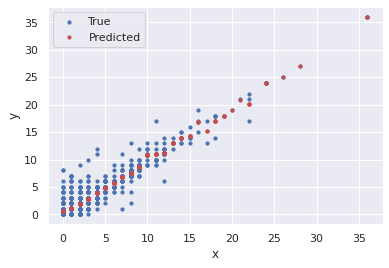

1.2531308847955935


In [ ]:
x4= rail4["delay"].to_numpy()
y4= rail5["delay"].to_numpy()
x4= x4.reshape(-1,1)
model4 = LinearRegression(fit_intercept=True)
model4.fit(x4, y4)
print("Model4 slope:    ", model4.coef_[0])
print("Model4 intercept:", model4.intercept_)
predict = model4.predict(x4)
plt.plot(x4,predict,c="red")
plt.scatter(x4,y4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model4.coef_[0]
l= model4.intercept_
x,y = symbols('x4,y4')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model4.score(x4,y4))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x4,y4)
predicted2=xgbrModel.predict(x4)
print("xg Score: ",xgbrModel.score(x4,y4))
plt.scatter(x4, y4, s=10, label='True')
plt.scatter(x4, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y4,predicted2)
print(sqrt(v))

**員林斗六減一分**

17.斗六到嘉義

Model5 slope:     0.9956512155392269
Model5 intercept: 1.1487234681005911


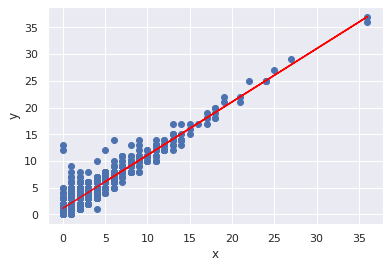

{x5: 264.148172543921, y5: 264.148172543921}
LR Score:  0.913310572734621
[04:00:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9154224414560106


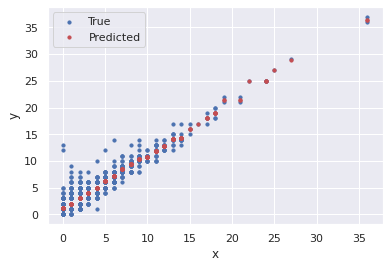

1.1704667375315279


In [ ]:

x5= rail5["delay"].to_numpy()
y5= rail6["delay"].to_numpy()
x5= x5.reshape(-1,1)
model5 = LinearRegression(fit_intercept=True)
model5.fit(x5, y5)
print("Model5 slope:    ", model5.coef_[0])
print("Model5 intercept:", model5.intercept_)
predict = model5.predict(x5)
plt.plot(x5,predict,c="red")
plt.scatter(x5,y5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model5.coef_[0]
l= model5.intercept_
x,y = symbols('x5,y5')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model5.score(x5,y5))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x5,y5)
predicted2=xgbrModel.predict(x5)
print("xg Score: ",xgbrModel.score(x5,y5))
plt.scatter(x5, y5, s=10, label='True')
plt.scatter(x5, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y5,predicted2)
print(sqrt(v))


**斗六嘉義不調整(嘉義工程)**

18.嘉義到台南

Model6 slope:     0.9866572685652627
Model6 intercept: -0.26418424149391617


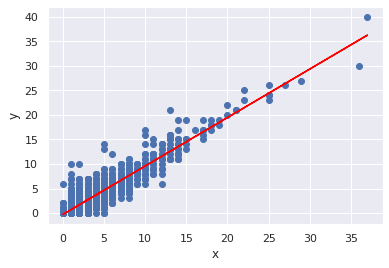

{x6: -19.7998620287094, y6: -19.7998620287094}
LR Score:  0.8405843319267639
[04:00:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8472751684041273


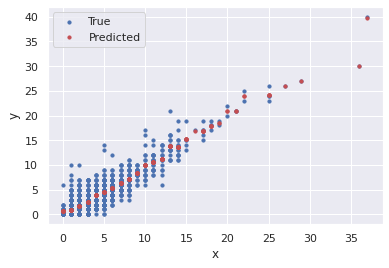

1.6926298904087027


In [ ]:
x6= rail6["delay"].to_numpy()
y6= rail7["delay"].to_numpy()
x6= x6.reshape(-1,1)
model6 = LinearRegression(fit_intercept=True)
model6.fit(x6, y6)
print("Model6 slope:    ", model6.coef_[0])
print("Model6 intercept:", model6.intercept_)
predict = model6.predict(x6)
plt.plot(x6,predict,c="red")
plt.scatter(x6,y6)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model6.coef_[0]
l= model6.intercept_
x,y = symbols('x6,y6')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model6.score(x6,y6))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x6,y6)
predicted21=xgbrModel.predict(x6)
print("xg Score: ",xgbrModel.score(x6,y6))
plt.scatter(x6, y6, s=10, label='True')
plt.scatter(x6, predicted21, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y6,predicted21)
print(sqrt(v))

**嘉義台南減1分**

18.嘉義到高雄


Model61 slope:     0.9204979738808413
Model61 intercept: -0.8722235863206294


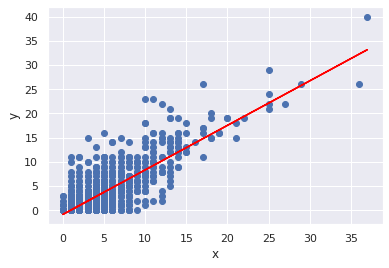

{x61: -10.9710862590260, y61: -10.9710862590260}
LR Score:  0.6786190061363371
[04:00:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.7010367900924497


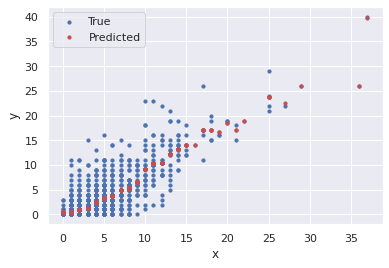

2.4419130906468354


In [ ]:
x61 = rail6.drop([29794])
x61= x61["delay"].to_numpy()
y61= rail9["delay"].to_numpy()
x61= x61.reshape(-1,1)
model61 = LinearRegression(fit_intercept=True)
model61.fit(x61, y61)
print("Model61 slope:    ", model61.coef_[0])
print("Model61 intercept:", model61.intercept_)
predict = model61.predict(x61)
plt.plot(x61,predict,c="red")
plt.scatter(x61,y61)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model61.coef_[0]
l= model61.intercept_
x,y = symbols('x61,y61')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model61.score(x61,y61))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x61,y61)
predicted61=xgbrModel.predict(x61)
print("xg Score: ",xgbrModel.score(x61,y61))
plt.scatter(x61, y61, s=10, label='True')
plt.scatter(x61, predicted61, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y61,predicted61)
print(sqrt(v))


**嘉義台南已調整**

19.台南到新左營

Model7 slope:     1.0035668768389023
Model7 intercept: 0.07161279815961352


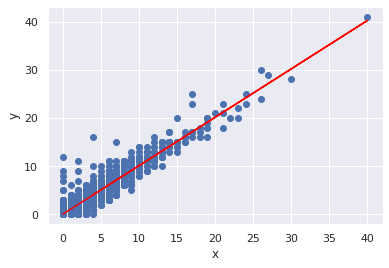

{x7: -20.0771715408313, y7: -20.0771715408313}
LR Score:  0.8867005897445964
[04:00:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8936802809687724


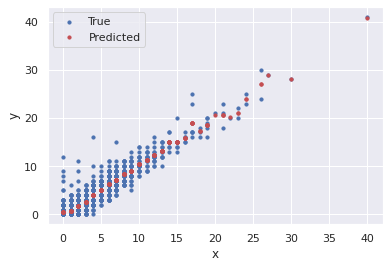

1.492376743521461


In [ ]:
x7= rail78["delay"].to_numpy()
y7= rail8["delay"].to_numpy()
x7= x7.reshape(-1,1)
model7 = LinearRegression(fit_intercept=True)
model7.fit(x7, y7)
print("Model7 slope:    ", model7.coef_[0])
print("Model7 intercept:", model7.intercept_)
predict = model7.predict(x7)
plt.plot(x7,predict,c="red")
plt.scatter(x7,y7)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model7.coef_[0]
l= model7.intercept_
x,y = symbols('x7,y7')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model7.score(x7,y7))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x7,y7)
predicted2=xgbrModel.predict(x7)
print("xg Score: ",xgbrModel.score(x7,y7))
plt.scatter(x7, y7, s=10, label='True')
plt.scatter(x7, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y7,predicted2)
print(sqrt(v))

20.台南到高雄

Model79 slope:     0.9392609039415054
Model79 intercept: -0.646238029816943


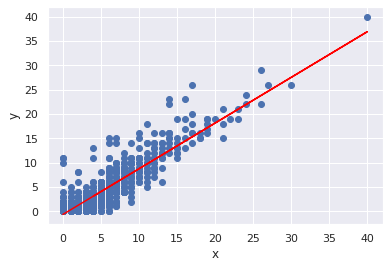

{x79: -10.6395727258532, y79: -10.6395727258532}
LR Score:  0.81575044127537
[04:00:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.8514091521770639


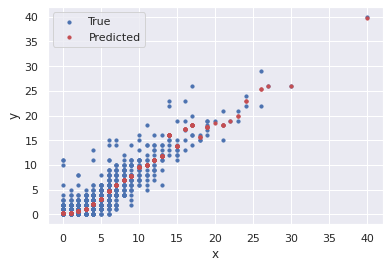

1.721540957289912


In [ ]:
x79= rail78["delay"].to_numpy()
y79= rail9["delay"].to_numpy()
x79= x7.reshape(-1,1)
model79 = LinearRegression(fit_intercept=True)
model79.fit(x79, y79)
print("Model79 slope:    ", model79.coef_[0])
print("Model79 intercept:", model79.intercept_)
predict = model79.predict(x79)
plt.plot(x79,predict,c="red")
plt.scatter(x79,y79)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model79.coef_[0]
l= model79.intercept_
x,y = symbols('x79,y79')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model79.score(x79,y79))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x79,y79)
predicted79=xgbrModel.predict(x79)
print("xg Score: ",xgbrModel.score(x79,y79))
plt.scatter(x79, y79, s=10, label='True')
plt.scatter(x79, predicted79, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y79,predicted79)
print(sqrt(v))

21.新左營到高雄

Model89 slope:     0.9389091455745926
Model89 intercept: -0.7243365137924922


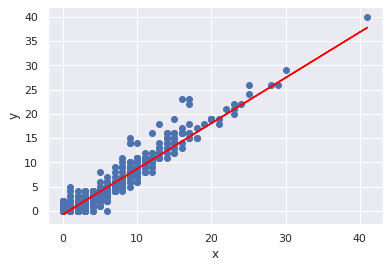

{x89: -11.8567094961312, y89: -11.8567094961312}
LR Score:  0.9258648687116113
[04:00:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xg Score:  0.9543206999279705


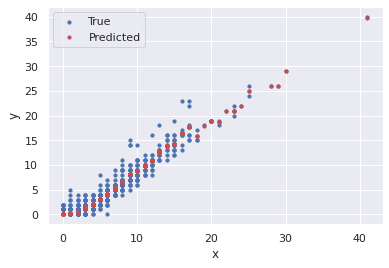

0.9545112458387872


In [ ]:
x89= rail8["delay"].to_numpy()
y89= rail9["delay"].to_numpy()
x89= x89.reshape(-1,1)
model89 = LinearRegression(fit_intercept=True)
model89.fit(x89, y89)
print("Model89 slope:    ", model89.coef_[0])
print("Model89 intercept:", model89.intercept_)
predict = model89.predict(x89)
plt.plot(x89,predict,c="red")
plt.scatter(x89,y89)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
k= model89.coef_[0]
l= model89.intercept_
x,y = symbols('x89,y89')
print(solve([k*x+l-y,x-y],[x,y]))
print("LR Score: ",model89.score(x89,y89))
xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(x89,y89)
predicted2=xgbrModel.predict(x89)
print("xg Score: ",xgbrModel.score(x89,y89))
plt.scatter(x89, y89, s=10, label='True')
plt.scatter(x89, predicted2, color="r",s=10, label='Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
v = mean_squared_error(y89,predicted2)
print(sqrt(v))